# Latent Dirchlet Allocation

In [1]:
# global imports
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
# pyspark
import findspark
findspark.init()
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
from pyspark.sql.types import StringType, IntegerType, ArrayType
# clustering algorithm
from pyspark.ml.clustering import LDA
# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

spark = SparkSession.builder.getOrCreate()
# specifications for visualizations
plt.style.use('seaborn')

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
# import train data
train = spark.createDataFrame(dfs[0])
train = train.drop('weights')
train.show(2)

+--------------------+-----+
|           count_vec|label|
+--------------------+-----+
|(495,[1,2,43,284]...|    0|
|(495,[0,2,7,8,10,...|    0|
+--------------------+-----+
only showing top 2 rows



In [4]:
# import vocab
vocab = dfs[3]

In [5]:
# import data
%store -r df2s

In [6]:
vocab2 = df2s[3]

In [7]:
sorted(vocab) == sorted(vocab2)

True

# Parameter Selection

Tune `max_iter` and `k`.

In [8]:
# number of topics to try
ks = [2,5,10,20]
max_iter = [10,20,50,100]
log_likelihoods = []
# obtain log likelihoods of the LDA for each number of topics
for k in ks:
    for m in max_iter:
        lda_k = LDA(featuresCol='count_vec').setK(k).setMaxIter(m).setSeed(414)
        lda_model_k = lda_k.fit(train)
        log_likelihoods.append([lda_model_k.logLikelihood(train),k,m])

In [9]:
max_log = log_likelihoods[0]
for i in range(len(log_likelihoods)):
    if log_likelihoods[i][0] > max_log[0]:
        max_log = log_likelihoods[i]
print("Largest log likelihood: ",max_log[0])
print("Best number of clusters: ",max_log[1])
print("Best max iteration: ",max_log[2])

Largest log likelihood:  -98949.46324723885
Best number of clusters:  2
Best max iteration:  100


# Final Model

In [10]:
# create final LDA model
lda = LDA(featuresCol='count_vec',k=2).setMaxIter(100).setSeed(414)
# fit model
lda_model = lda.fit(train)
# transform data
train_topics = lda_model.transform(train)
train_topics.show(2)

+--------------------+-----+--------------------+
|           count_vec|label|   topicDistribution|
+--------------------+-----+--------------------+
|(495,[1,2,43,284]...|    0|[0.28117788848580...|
|(495,[0,2,7,8,10,...|    0|[0.80251198587079...|
+--------------------+-----+--------------------+
only showing top 2 rows



# Words in Each Topic

In [11]:
# obtain term indices for each topic
topics = lda_model.describeTopics(75)
topics.show(2)

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[3, 2, 5, 7, 1, 9...|[0.02731772269326...|
|    1|[0, 1, 6, 12, 4, ...|[0.08243648783483...|
+-----+--------------------+--------------------+



In [12]:
# function for converting index to word
def index_to_word(row):
    new_row = []
    for item in row:
        new_row.append(vocab[item])
    return new_row
# udf for converting index to word
index_to_word_udf = W.udf(lambda row: index_to_word(row), ArrayType(StringType()))
# add column of words corresponding to each index
topics = topics.withColumn('topic_words', index_to_word_udf('termIndices'))
# output dataframe
topics.show(2)

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|
+-----+--------------------+--------------------+--------------------+
|    0|[3, 2, 5, 7, 1, 9...|[0.02731772269326...|[alexa, great, li...|
|    1|[0, 1, 6, 12, 4, ...|[0.08243648783483...|[love, echo, use,...|
+-----+--------------------+--------------------+--------------------+



In [13]:
# function for whole number of weights (used for word cloud frequencies)
def weights_whole(row):
    weights = []
    for item in row:
        weights.append(int(item*10000))
    return weights
# udf for whole number of weights
weights_whole_udf = W.udf(lambda row: weights_whole(row), ArrayType(IntegerType()))
# add column with whole number of weights
topics = topics.withColumn('weights_whole', weights_whole_udf('termWeights'))
# output dataframe
topics.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|         topic_words|       weights_whole|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|[3, 2, 5, 7, 1, 9...|[0.02731772269326...|[alexa, great, li...|[273, 222, 208, 1...|
|    1|[0, 1, 6, 12, 4, ...|[0.08243648783483...|[love, echo, use,...|[824, 473, 367, 3...|
+-----+--------------------+--------------------+--------------------+--------------------+



In [14]:
# function for creating word cloud
def wordcloudplot(lda,topics):
    for k in range(lda.getK()):
        topick = topics.where(W.col('topic') == k)
        topick_dict = {}
        for i,v in zip(topick.select('topic_words').rdd.map(lambda x:x[0]).collect()[0],topick.select('weights_whole').rdd.map(lambda x:x[0]).collect()[0]):
            topick_dict[i] = v
        cloud = WordCloud()
        plt.figure(figsize=(8,6))
        cloud.generate_from_frequencies(topick_dict)
        plt.imshow(cloud)
        plt.axis("off")
        plt.margins(x=0, y=0)
        plt.show()

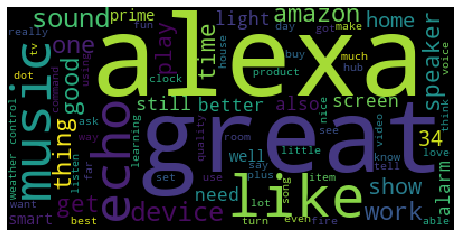

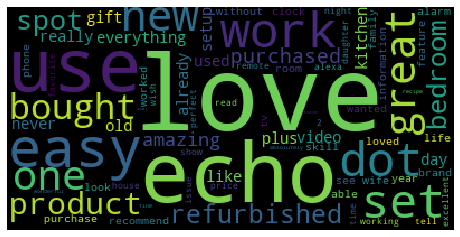

In [15]:
# create word cloud for each topic
wordcloudplot(lda,topics)

LDA does not separate the dataset into clear topics since both topics contain positive words related to Amazon Alexas and its uses. Since all reviews contain many similar words, differentiating between topics is challenging.

# Topic Distribution

## Visualization

In [16]:
# function for histogram of topic distribution
def hist_topic_dist(positive,negative,title):
    # obtain density
    xs = np.linspace(0,1,200)
    pos_density = gaussian_kde(positive)
    pos_density.covariance_factor = lambda : .25
    pos_density._compute_covariance()
    neg_density = gaussian_kde(negative)
    neg_density.covariance_factor = lambda : .25
    neg_density._compute_covariance()
    # create a histogram
    plt.figure(figsize=(8,6))
    plt.hist(positive,bins=15,density=True,alpha=0.4)
    plt.hist(negative,bins=15,density=True,alpha=0.4)
    plt.plot(xs,pos_density(xs),color='C0')
    plt.plot(xs,neg_density(xs),color='C1')
    plt.xlabel('Distribution',fontsize=14,weight='bold')
    plt.ylabel('Density',fontsize=14,weight='bold')
    plt.title('Histogram of '+title,fontsize=18,weight='bold')
    # create legend
    plt.legend(['Positive','Negative'],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
    plt.show()

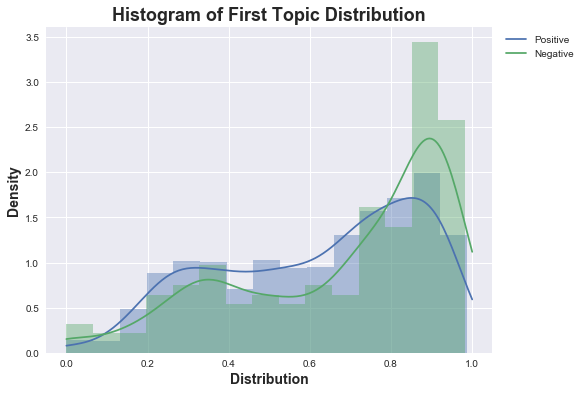

In [17]:
# create histogram of first topic distribution
pos_topic1 = train_topics.where(W.col('label')==0).select('topicDistribution').rdd.map(lambda row:row[0][0]).collect()
neg_topic1 = train_topics.where(W.col('label')==1).select('topicDistribution').rdd.map(lambda row:row[0][0]).collect()
hist_topic_dist(pos_topic1,neg_topic1,'First Topic Distribution')

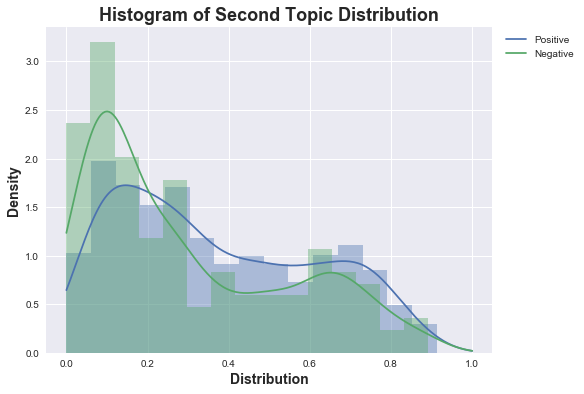

In [18]:
# create histogram of first topic distribution
pos_topic2 = train_topics.where(W.col('label')==0).select('topicDistribution').rdd.map(lambda row:row[0][1]).collect()
neg_topic2 = train_topics.where(W.col('label')==1).select('topicDistribution').rdd.map(lambda row:row[0][1]).collect()
hist_topic_dist(pos_topic2,neg_topic2,'Second Topic Distribution')

The histograms of topic distributions show that positive reviews are somewhat uniformly distributed amongst both topics. On the contrary, negative reviews are more heavily weighted towards the first topic.

## Mann-Whitney U Test

Null hypothesis: the ranks are uniformly distributed and the distributions of positive and negative topics are identical. Alternative hypothesis: the distributions of positive and negative topics are not identical.

In [19]:
# topic 1
stat, p = mannwhitneyu(pos_topic1, neg_topic1)
if p < 0.05:
    print('Statistically Significant')
else:
    print ('Not Statistically Significant')

Statistically Significant


Since my p value is less than alpha=0.05, I have statistically singificant evidence to reject the null hypothesis. The distributions of positive and negative reviews are not identical for the first topic. 

In [20]:
# topic 2
stat, p = mannwhitneyu(pos_topic2, neg_topic2)
if p < 0.05:
    print('Statistically Significant')
else:
    print ('Not Statistically Significant')

Statistically Significant


Since my p value is less than alpha=0.05, I have statistically singificant evidence to reject the null hypothesis. The distributions of positive and negative reviews are not identical for the second topic. 